# Peter e il Lupo: Ambiente Realistico

Nella nostra situazione, Peter è stato in grado di muoversi quasi senza stancarsi o avere fame. In un mondo più realistico, deve sedersi e riposare di tanto in tanto, oltre a nutrirsi. Rendiamo il nostro mondo più realistico implementando le seguenti regole:

1. Spostandosi da un luogo all'altro, Peter perde **energia** e accumula **fatica**.
2. Peter può recuperare energia mangiando mele.
3. Peter può eliminare la fatica riposando sotto un albero o sull'erba (cioè entrando in una posizione sulla mappa con un albero o un prato - campo verde).
4. Peter deve trovare e uccidere il lupo.
5. Per uccidere il lupo, Peter deve avere determinati livelli di energia e fatica, altrimenti perde la battaglia.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

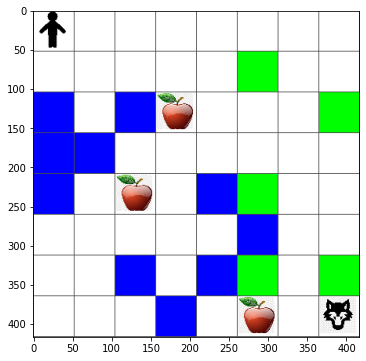

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Definire lo stato

Nelle nuove regole del nostro gioco, dobbiamo tenere traccia dell'energia e della fatica in ogni stato del tabellone. Pertanto, creeremo un oggetto `state` che conterrà tutte le informazioni necessarie sullo stato attuale del problema, inclusi lo stato del tabellone, i livelli attuali di energia e fatica, e se possiamo sconfiggere il lupo quando siamo nello stato terminale:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Funzione di Ricompensa

La funzione di ricompensa è un componente fondamentale per il successo del tuo modello. Essa guida il comportamento dell'agente, incentivandolo a raggiungere gli obiettivi desiderati.

### Obiettivi della Funzione di Ricompensa

- **Definire il comportamento desiderato:** La funzione di ricompensa deve riflettere chiaramente ciò che vuoi che l'agente faccia.
- **Evitare comportamenti indesiderati:** È importante penalizzare azioni che portano a risultati non voluti.
- **Bilanciare incentivi:** Assicurati che le ricompense siano proporzionate e non causino squilibri nel comportamento dell'agente.

### Linee Guida per Scrivere una Funzione di Ricompensa

1. **Sii specifico:** Definisci chiaramente quali azioni meritano una ricompensa e quali una penalità.
2. **Mantieni la semplicità:** Una funzione di ricompensa troppo complessa può rendere difficile l'addestramento del modello.
3. **Testa e ottimizza:** Prova diverse configurazioni per trovare quella che produce i migliori risultati.

### Esempio di Funzione di Ricompensa

```python
def reward_function(state, action):
    if action == "goal_reached":
        return 10  # Ricompensa per aver raggiunto l'obiettivo
    elif action == "undesired_action":
        return -5  # Penalità per azioni indesiderate
    else:
        return 0  # Nessuna ricompensa o penalità
```

### [!TIP] Suggerimenti Utili

- **Usa valori scalari:** Mantieni le ricompense e penalità semplici, come numeri interi o decimali.
- **Evita ambiguità:** Assicurati che ogni azione abbia una ricompensa o penalità ben definita.
- **Monitora i risultati:** Analizza il comportamento dell'agente per verificare che la funzione di ricompensa stia funzionando come previsto.

### [!WARNING] Errori Comuni

- **Ricompense troppo alte o basse:** Possono causare problemi di convergenza durante l'addestramento.
- **Ignorare penalità:** Senza penalità, l'agente potrebbe adottare comportamenti non ottimali.
- **Non testare la funzione:** Una funzione di ricompensa non testata può portare a risultati imprevedibili.

### Conclusione

La funzione di ricompensa è uno strumento potente per modellare il comportamento dell'agente. Investi tempo nella sua progettazione e ottimizzazione per garantire il successo del tuo modello.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Algoritmo Q-Learning

L'algoritmo di apprendimento vero e proprio rimane praticamente invariato, utilizziamo semplicemente `state` invece della sola posizione sulla scacchiera.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

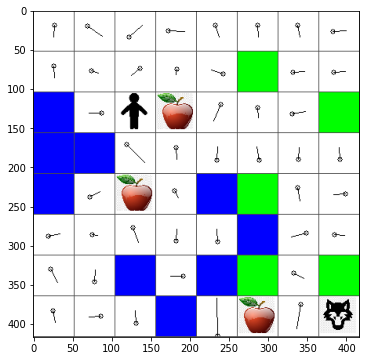

In [11]:
m.plot(Q)

## Risultati

Vediamo se siamo riusciti ad addestrare Peter a combattere il lupo!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Ora vediamo molti meno casi di annegamento, ma Peter non riesce ancora sempre a uccidere il lupo. Prova a sperimentare e vedi se puoi migliorare questo risultato giocando con gli iperparametri.


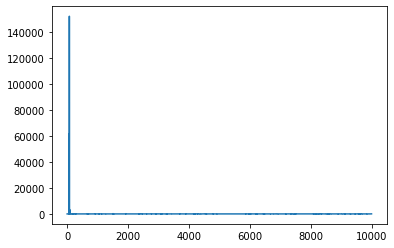

In [13]:
plt.plot(lpath)


---

**Disclaimer**:  
Questo documento è stato tradotto utilizzando il servizio di traduzione automatica [Co-op Translator](https://github.com/Azure/co-op-translator). Sebbene ci impegniamo per garantire l'accuratezza, si prega di notare che le traduzioni automatiche possono contenere errori o imprecisioni. Il documento originale nella sua lingua nativa dovrebbe essere considerato la fonte autorevole. Per informazioni critiche, si raccomanda una traduzione professionale effettuata da un traduttore umano. Non siamo responsabili per eventuali incomprensioni o interpretazioni errate derivanti dall'uso di questa traduzione.
